# 1.Introduction
这是一个在MNIST数据集上训练的用于数字识别的5层顺序卷积神经网络。我选择使用keras API（Tensorflow后端）构建它，这非常直观。首先，我将准备数据（手写数字图像），然后我将专注于CNN建模和评估。
我在2h30在单个CPU（i52500k）上训练了这个CNN，达到了99.671%的准确率。对于那些拥有>=3.0 GPU功能（从GTX 650到最近的GPU）的人，您可以将tenorflow-gpu与keras一起使用。计算会快得多！！！
出于计算原因，我将步数（纪元）设置为2，如果您想达到99+%的精度，请将其设置为30。  
本笔记本分为三个主要部分：  
数据准备  
CNN建模与评估  
结果预测和提交  

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# 2.Data preparation
## 2.1 Load data

In [63]:
# Load the data
train = pd.read_csv("./digit-recognizer/train.csv")
test = pd.read_csv("./digit-recognizer/test.csv")
# train = pd.read_csv("./digit-recognizer/train.csv", nrows = 2000)
# test = pd.read_csv("./digit-recognizer/test.csv", nrows = 2000)

In [64]:
# 将训练数据集中的"label"列提取出来，并赋值给变量Y_train。这表示目标变量（或标签），它包含了训练样本的正确分类。
Y_train = train["label"]
# 这一行代码从训练数据集中删除了"label"列，并将剩余的特征数据赋值给变量X_train。
X_train = train.drop(labels = ["label"],axis = 1) 
# 将名为train的数据集从内存中删除，以释放一些空间。
del train 
# 使用Seaborn库绘制了Y_train中不同类别的计数直方图。
# g = sns.countplot(X_train)
# 计算了Y_train中每个类别的样本数量，并返回一个包含每个类别及其对应样本数量的Series对象。
Y_train.value_counts()
# 10个数的频率相差不大

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

## 2.2 Check for null and missing values

In [65]:
# Check the data
# X_train.isnull(): 这一部分代码检查X_train中的每个元素是否为缺失值（NaN）。
# any()方法在布尔值数据框的列上执行逻辑或操作，返回一个包含每列是否存在缺失值的布尔值Series。
# describe()方法计算布尔值Series的描述性统计信息
X_train.isnull().any().describe()
# count：表示非缺失值的数量。
# unique：表示唯一值的数量。
# top：表示出现频率最高的值。
# freq：表示出现频率最高的值的频率。
# dtype：表示数据类型。

count       784
unique        1
top       False
freq        784
dtype: object

In [66]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

我检查损坏的图像（内部缺少值）。
训练和测试数据集中没有缺失值。所以我们可以安全地继续。

## 2.3 Normalization
我们执行灰度归一化以减少光照差异的影响。
此外，CNN在[0…1]数据上的转换速度比在[0…255]上的转换速度更快。

In [67]:
# Normalize the data
# 将X_train数据集中的所有像素值除以255.0。
# 由于像素值通常范围在0到255之间（对应灰度图像的颜色强度），除以255.0可以将像素值缩放到0到1的范围内。
X_train = X_train / 255.0
test = test / 255.0

## 2.4 Reshape

In [68]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# 将X_train数据集的形状进行重塑。原本的X_train数据集是一个二维的矩阵，每一行代表一张图像，每一列代表图像的像素值。
# 通过reshape()方法，将图像数据集重塑为一个四维矩阵，其中-1表示根据数据集大小自动计算行数，
# 28表示图像的高度（28像素），28表示图像的宽度（28像素），1表示通道数（此处为灰度图像，通道数为1）。
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

训练和测试图像（28px x 28px）已存入pandas。数据帧作为784个值的一维向量。我们将所有数据重塑为28x28x1 3D矩阵。
Keras最终需要一个额外的维度来对应通道。MNIST图像是灰度缩放的，因此它只使用一个通道。对于RGB图像，有3个通道，我们会将784px向量重塑为28x28x3 3D矩阵。
## 2.5 Label encoding

In [69]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
# to_categorical是一个函数或方法（可能是自定义的），用于将标签数据进行独热编码。
# Y_train是原始的标签数据。
# num_classes指定了独热编码后向量的长度，这里设为10，代表总共有10个类别。
Y_train = to_categorical(Y_train, num_classes = 10)

标签是从0到9的10位数字。我们需要将这些标签编码为一个热向量（例如：2->[0,0,1,0,0,0,0,0,0]）。
## 2.6 Split training and valdiation set
我选择将训练集分成两部分：一小部分（10%）成为评估模型的验证集，其余部分（90%）用于训练模型。

由于我们有42 000个平衡标签的训练图像（参见2.1 Load数据），因此随机拆分训练集不会导致某些标签在验证集中过度表示。小心一些不平衡的数据集，简单的随机拆分可能会导致验证期间的评估不准确。

为了避免这种情况，您可以在train_test_split函数中使用stratify=True选项（仅适用于>=0.17 sklearn版本）。

In [70]:
# 通过设置随机种子，可以使随机过程在每次运行时都产生相同的结果，以保证实验的可重复性。
random_seed = 2
# 使用train_test_split函数将训练数据集X_train和标签数据集Y_train拆分成训练集X_train、验证集X_val、训练集标签Y_train和验证集标签Y_val。
# X_train和Y_train是原始的训练数据集和标签数据集。
# test_size = 0.1表示将10%的数据分配给验证集，即验证集占总训练数据的比例为10%。
# random_state=random_seed表示使用之前设置的随机种子2来控制数据的拆分过程，确保每次运行时都得到相同的拆分结果。
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

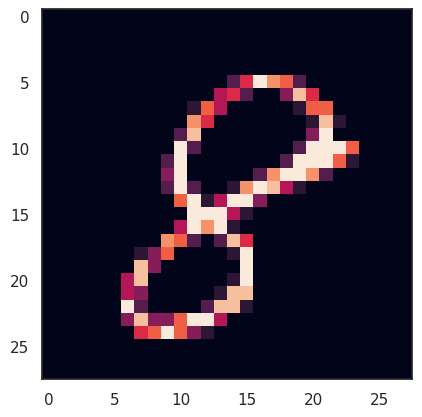

In [71]:
# 我们可以通过视觉化图像和查看标签来更好地理解其中一个例子。
# X_train是训练集数据，其中索引为0的样本被选中进行可视化。
# X_train[0]表示训练集中的第一个样本。
# [:,:,0]表示选择第一个样本的所有行和列，并且选择通道为0的部分。
# 这里的0表示灰度图像的通道索引，因为之前的操作将图像数据重塑为四维张量，其中最后一个维度是通道维度。
g = plt.imshow(X_train[0][:,:,0])

# 3.CNN
## 3.1 Define the model
我使用了Keras Sequential API，您只需一次添加一层，从输入开始。

第一个是卷积（Conv2D）层。它就像一组可学习的过滤器。我选择为两个第一个卷积2D层设置32个过滤器，为最后两个设置64个过滤器。每个过滤器使用内核过滤器转换图像的一部分（由内核大小定义）。内核过滤器矩阵应用于整个图像。过滤器可以看作是图像的转换。

CNN可以从这些转换后的图像（特征图）中分离出在任何地方都有用的特征。

CNN中的第二个重要层是池化（MaxPool2D）层。该层简单地充当下采样过滤器。它查看2个相邻像素并选择最大值。这些用于降低计算成本，并在某种程度上减少过拟合。我们必须选择池化大小（即每次池化的区域大小）池化维度越高，下采样就越重要。

结合卷积层和池化层，CNN能够结合局部特征并学习图像的更多全局特征。

Dropout是一种正则化方法，对于每个训练样本，层中的一部分节点被随机忽略（将它们的重量设置为零）。这会随机丢弃网络的比例，并迫使网络以分布式方式学习特征。这种技术还提高了泛化并减少了过拟合。

'relu'是整流器（激活函数max（0， x）。整流器激活函数用于向网络添加非线性。

扁平化层用于将最终的特征图转换为一个单一的一维向量。需要这个扁平化步骤，以便您可以在一些卷积/最大池层之后使用完全连接的层。它结合了以前卷积层的所有发现的局部特征。

最后，我在两个全连接（密集）层中使用了特征，这只是人工神经网络（ANN）分类器。在最后一层（密集（10，激活="softmax"））中，网络输出每个类的概率分布。

In [72]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
# 创建一个Sequential模型对象，用于构建CNN模型。
model = Sequential()
# 添加第一个卷积层。这个卷积层有32个滤波器（filters），每个滤波器的大小为5x5。
# padding参数设置为'Same'，表示使用零填充来保持输入和输出的大小相同。激活函数使用ReLU。
# input_shape参数指定输入的形状为(28, 28, 1)，即图像的高度为28像素，宽度为28像素，通道数为1（灰度图像）。
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
# 添加第二个卷积层，与前面的卷积层类似。
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
# 添加最大池化层。这个池化层的池化窗口大小为2x2，通过降低特征图的空间尺寸来减少参数数量。
model.add(MaxPool2D(pool_size=(2,2)))
# 添加一个dropout层，以减少过拟合。这里的0.25表示丢弃输入单元的比例为25%。
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# 展平层（将多维输入展平为一维）
model.add(Flatten())
# 一个全连接层（256个神经元，使用ReLU激活函数）
model.add(Dense(256, activation = "relu"))
# 一个dropout层（丢弃输入单元的比例为50%）
model.add(Dropout(0.5))
# 一个全连接层（10个神经元，使用softmax激活函数）
model.add(Dense(10, activation = "softmax"))

## 3.2 Set the optimizer and annealer
一旦我们的层被添加到模型中，我们需要设置一个分数函数、一个损失函数和一个优化算法。

我们定义损失函数来衡量我们的模型在具有已知标签的图像上的表现有多差。它是观察标签和预测标签之间的错误率。我们使用一种特定的形式进行分类（>2类），称为“categorical_crossentropy”。

最重要的功能是优化器。该函数将迭代改进参数（过滤内核值、权重和神经元的偏差……）以最大限度地减少损失。

我选择了RMSprop（具有默认值），它是一个非常有效的优化器。RMSProp更新以非常简单的方式调整Adagrad方法，试图降低其激进的、单调递减的学习率。我们也可以使用随机梯度下降（'sgd'）优化器，但它比RMSprop慢。

使用的度量函数“准确度”是评估我们模型的性能，这个度量函数与损失函数类似，只是训练模型时不使用度量评估的结果（仅用于评估）。